## Overview

In this notebook, we are going to take a look at patterns in employee churns across several companies and departments. We are interested in any patterns found in churned employees, specifically, it would be very nice to identify factors mostly related to possibility of churn, and develop a classification model to predict potential churns.

### 1. Data Exploration

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date 

In [57]:
#read in data
data = pd.read_csv("Data/employee_retention_data.csv")
print(data.shape)
data.head()

(24702, 7)


,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [58]:
data.dtypes #need to convert dept to str and dates to datetime objects
data["company_id"] = data["company_id"].apply(lambda x:str(x))
data.dtypes

employee_id    float64
company_id      object
dept            object
seniority        int64
salary         float64
join_date       object
quit_date       object
dtype: object

In [59]:
data.loc[:,"join_date"] = pd.to_datetime(data["join_date"], infer_datetime_format=True) 
data.loc[:,"quit_date"] = pd.to_datetime(data["quit_date"], infer_datetime_format=True) 

In [60]:
max((data["quit_date"] -data["join_date"]).dt.days)

1726.0

In [61]:
#add another column of work duration
data.loc[:,"duration"] = (data["quit_date"] -data["join_date"])

In [62]:
data.loc[:,"quit_year"] = data["quit_date"].dt.year
data.loc[:,"quit_month"] = data["quit_date"].dt.month
data.loc[:,"join_year"] = data["join_date"].dt.year
data.loc[:,"join_month"] = data["join_date"].dt.month

In [63]:
pd.to_datetime('2015-12-13 00:00:00') - min(data["join_date"])

Timedelta('1784 days 00:00:00')

In [64]:
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,duration,quit_year,quit_month,join_year,join_month
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585 days,2015.0,10.0,2014,3
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340 days,2014.0,4.0,2013,4
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaT,NaN,NaN,2014,10
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389 days,2013.0,6.0,2012,5
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040 days,2014.0,8.0,2011,10


In [65]:
#Assign NaT/NaN to another category
data.loc[:,"duration"][data.quit_date.isnull()] = pd.to_timedelta('1784 days')
data.loc[:,"duration"] = data["duration"].dt.days
data.loc[:,"length_employed"] = 0
data.loc[:,"length_employed"][~data["quit_date"].isna()] = data["duration"][~data["quit_date"].isna()] 

Add a column named length_employed, which equals to duration for churned employees, and current work length for continuing employees

In [66]:
data.loc[:,"length_employed"][data["quit_date"].isna()] = (pd.to_datetime('2015-12-13 00:00:00')-data["join_date"]).dt.days

In [67]:
data.loc[:,"binary"] = (data["duration"] == 1784).astype(str) #True for continuing employees

In [68]:
#find durations of churned employees
churn_duration = data["duration"][data["duration"]!=1780]
np.mean(churn_duration),max(churn_duration) #mean and max employment length of churned employees

(1143.8237794510567, 1784)

<AxesSubplot:xlabel='duration'>

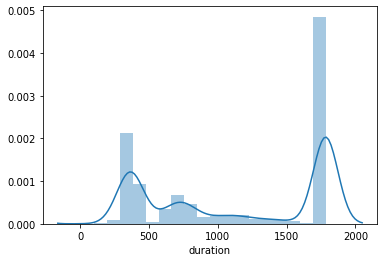

In [69]:
#distribution of durations, tri-modal
sns.distplot(churn_duration)

In [70]:
#three classes according to distribution of durations,0-500,500-900,>900
pd.options.mode.chained_assignment = None 
data.loc[:,"category"] = ""
data.loc[:,"category"][data["duration"]<500] = "short-term"
data.loc[:,"category"][(data["duration"]>=500)&(data["duration"]<900)] = "medium-term"
data.loc[:,"category"][(data["duration"]>=900)&(data["duration"]<=1726)] = "long-term"
data.loc[:,"category"][data["duration"]==1784] = "continuing"

In [71]:
#investifate unusual data points, unusual seniority data
data.describe()

,employee_id,seniority,salary,duration,quit_year,quit_month,join_year,join_month,length_employed
count,24702.000000,24702.000000,24702.000000,24702.000000,13510.00000,13510.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,14.127803,138183.345478,1143.823779,2013.83242,6.550925,2012.995709,6.494899,574.319083
std,288909.026101,8.089520,76058.184573,631.335273,1.05116,3.408746,1.395940,3.401531,361.592379
min,36.000000,1.000000,17000.000000,102.000000,2011.00000,1.000000,2011.000000,1.000000,3.000000
25%,250133.750000,7.000000,79000.000000,403.000000,2013.00000,4.000000,2012.000000,4.000000,333.000000
50%,500793.000000,14.000000,123000.000000,1173.000000,2014.00000,7.000000,2013.000000,6.000000,424.000000
75%,753137.250000,21.000000,187000.000000,1784.000000,2015.00000,10.000000,2014.000000,9.000000,781.000000
max,999969.000000,99.000000,408000.000000,1784.000000,2015.00000,12.000000,2015.000000,12.000000,1777.000000


<AxesSubplot:xlabel='seniority'>

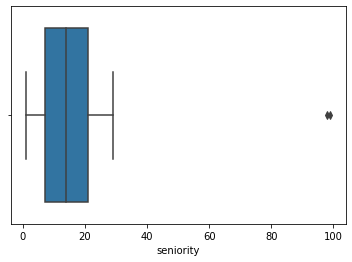

In [72]:
sns.boxplot(data["seniority"])

In [73]:
#drop two outliers
data = data[data["seniority"]<50]

In [74]:
data["category"].value_counts()

continuing     11192
short-term      7340
medium-term     3706
long-term       2462
Name: category, dtype: int64

### 2. EDA
### Potential Questions:

#### Nature of distributions of features:
1. Seniority distribution
2. Company distribution (how many rows for each company
    
#### Joint distribution of independent features and churn categories:
1. Number of churns per company
2. churn by segment and company
3. average duration per segment/company
4. average salary
5. average seniority per company




<AxesSubplot:xlabel='seniority'>

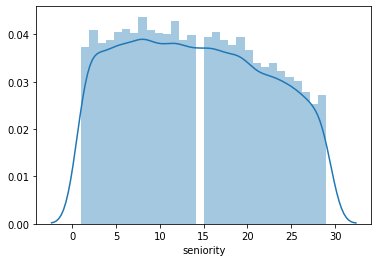

In [20]:
#distribution of seniority, mostly balaced, with decreasing trend as seniroity increases
sns.distplot(data["seniority"])

<AxesSubplot:xlabel='company_id', ylabel='salary'>

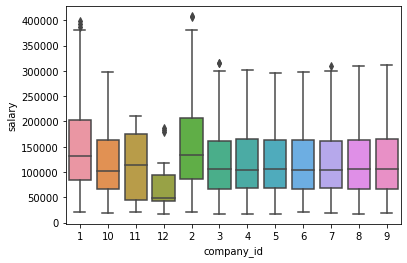

In [21]:
#distribution of salary by company
sns.boxplot(data["company_id"],data["salary"])

Most companies have similar level of salary, company 1, 2 and 11 have higher median salary and company 12 has a much lower median salary (with one outlier of high salary), it will be interesting to see if this correlates with patterns of churns.

<AxesSubplot:xlabel='company_id', ylabel='seniority'>

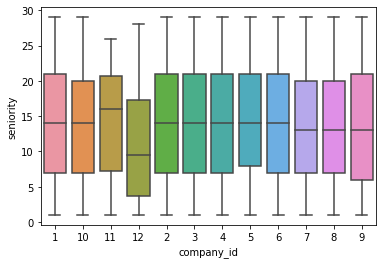

In [22]:
sns.boxplot("company_id","seniority",data=data)

Most companies have similar level of seniority, company 11 has a higher median seniority and company 12 has the lowest median seniority. There are no extreme outliers, so the overall distributions are within a reasonable range. The patterns of seniority might correlate with the patterns of salary shown above.

<AxesSubplot:xlabel='company_id', ylabel='join_year'>

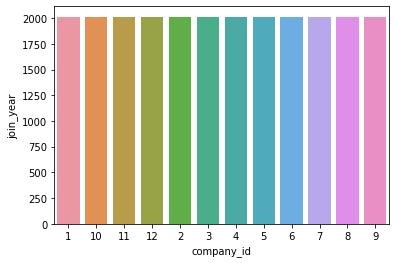

In [47]:
#number of new employees per year by company
sns.barplot("company_id","join_year",data=data)

<AxesSubplot:ylabel='binary'>

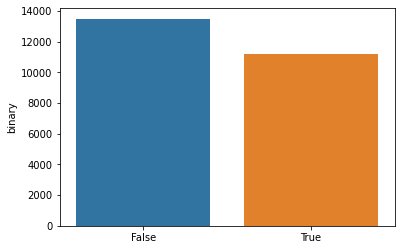

In [23]:
sns.barplot(data["binary"].value_counts().index,data["binary"].value_counts())

There are more churned employees than continuing employees in this dataset.

Text(0, 0.5, 'Employee Counts')

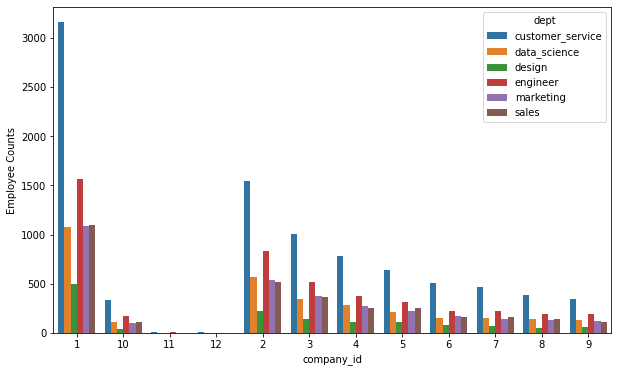

In [24]:
#by company and department
plt.figure(figsize=(10,6))
company_dept = data.groupby(['company_id',"dept"]).agg(len).reset_index()
sns.barplot("company_id","employee_id",data = company_dept,hue = "dept")
plt.ylabel("Employee Counts")

Distribution of number of employess is skewed, with most number of employees from company 1, within each company, the distribution of employees by department is similar, with the top 2 departments being customer service and engineer.

<AxesSubplot:xlabel='company_id', ylabel='length_employed'>

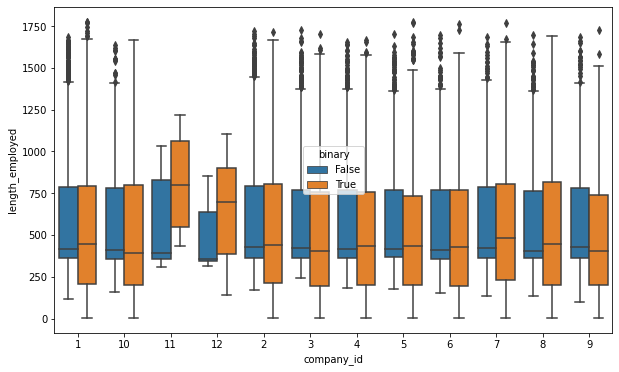

In [25]:
plt.figure(figsize=(10,6))
sns.boxplot("company_id","length_employed",hue="binary",data=data)

For company 11 and 12, there are significant differences between churned and continuing employees, and churned employess tend to be in the company shorter than continuing employees.

<AxesSubplot:xlabel='dept', ylabel='length_employed'>

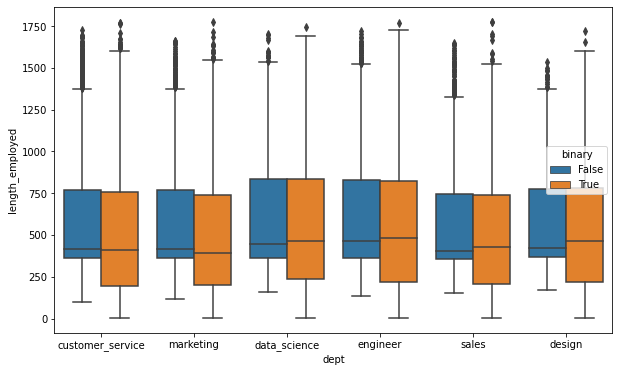

In [26]:
plt.figure(figsize=(10,6))
sns.boxplot("dept","length_employed",hue="binary",data=data)

Similar employed length among departments for churned and continuing employees

<AxesSubplot:xlabel='company_id', ylabel='salary'>

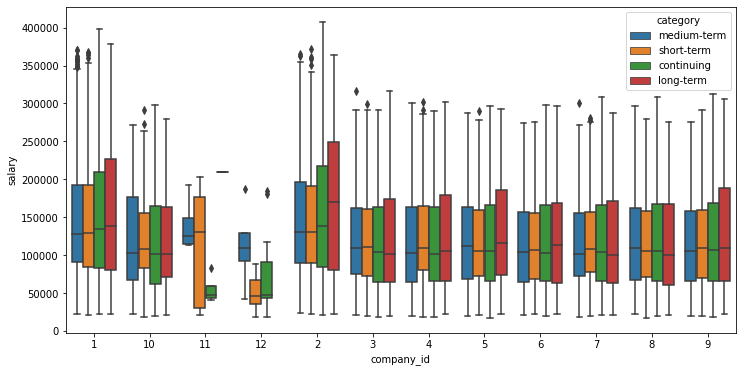

In [27]:
plt.figure(figsize=(12,6))
sns.boxplot("company_id","salary",hue="category",data=data)

<AxesSubplot:xlabel='company_id', ylabel='seniority'>

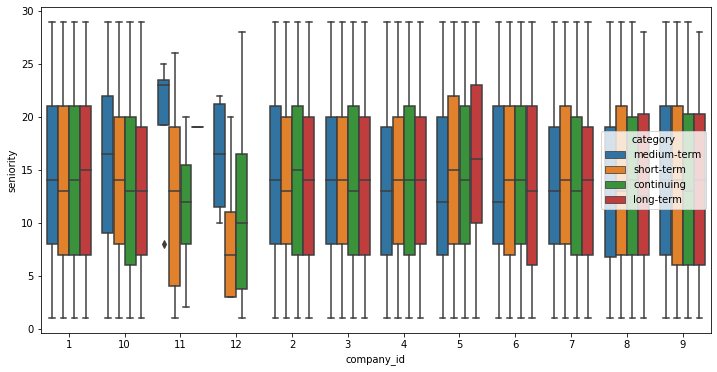

In [28]:
plt.figure(figsize=(12,6))
sns.boxplot("company_id","seniority",hue="category",data=data)

There are almost no long-term churned employees in company 11 and 12, and there are significant differences in both seniority and salary among churned categories. Seniority in company 11 and 12 indicates that medium-term employees have much higher seniority than short-term employees, which is worth taking a look at deeper reaosns.

Text(0.5, 0, 'Continuing?')

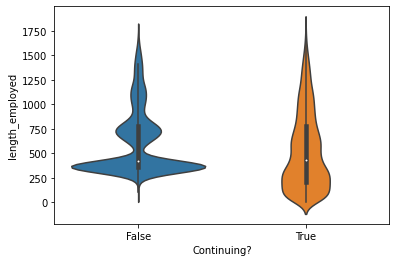

In [30]:
sns.violinplot("binary","length_employed",data=data)
plt.xlabel("Continuing?")

Churned employees and continuing employees have similar median, but the multi-modal shape is much more obvious among churned employees.

### 3. Modeling

- Our goal is to predict the future binary class label at a specific time point
    1. Logistic Regression
    2. Decision Tree

#### Features
- Categorical: company_id, department
- Numerical: Salary, Seniority, Duration (to be calculated) 

In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [75]:
#training: quit before 2015/07/01 but after 2014-07-01, join before 2014/07/01
train_df = data[(data["quit_date"]<"2015-07-01")|(data["quit_date"].isna())]
train_df= train_df[(train_df["quit_date"]>="2014-07-01")|(train_df["quit_date"].isna())]
train_df= train_df[(train_df["join_date"]<"2014-07-01")]
train_df.head()
#recalculate using 2014/07/01-join_date as length employed

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,duration,quit_year,quit_month,join_year,join_month,length_employed,binary,category
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040,2014.0,8.0,2011,10,1040,False,long-term
6,88600.0,4,customer_service,21,107000.0,2013-10-21,NaT,1784,NaN,NaN,2013,10,783,True,continuing
7,716309.0,2,customer_service,4,30000.0,2014-03-05,NaT,1784,NaN,NaN,2014,3,648,True,continuing
9,504159.0,1,sales,7,104000.0,2012-06-12,NaT,1784,NaN,NaN,2012,6,1279,True,continuing
10,892155.0,6,customer_service,13,72000.0,2012-11-12,2015-02-27,837,2015.0,2.0,2012,11,837,False,medium-term


In [76]:
train_df["binary"].value_counts()

True     4807
False    4440
Name: binary, dtype: int64

In [97]:
binary_train = train_df[['company_id', 'dept', 'seniority', 'salary']]
binary_train.loc[:,"length"] = (pd.to_datetime('2014-07-01') - train_df["join_date"]).dt.days

In [101]:
binary_train.dtypes

company_id     object
dept           object
seniority       int64
salary        float64
length          int64
dtype: object

In [189]:
# y label in training set
binary_train_y = train_df["binary"]
binary_train_y.head()

4     False
6      True
7      True
9      True
10    False
Name: binary, dtype: object

In [105]:
#X matrix for training
binary_train_df = pd.get_dummies(binary_train,drop_first=True)
binary_train_df.head()

,seniority,salary,length,company_id_10,company_id_11,company_id_12,company_id_2,company_id_3,company_id_4,company_id_5,company_id_6,company_id_7,company_id_8,company_id_9,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
4,23,276000.0,988,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
6,21,107000.0,253,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
7,4,30000.0,118,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9,7,104000.0,749,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10,13,72000.0,596,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [190]:
#built logistic model
logistic = LogisticRegression(random_state=0).fit(binary_train_df, binary_train_y)

Assume I am at 2015/9/1, I want to predict who are going to churn in later half of 2015, testing set contains all people who are continuing on 2015/9/1
- Testing data: those who churned after 2015/9/1, plus an equal amount of sample from continuing employees 
For testing, recalculate binary label and length employed according to 2015/09/01 - join_date


In [108]:
#test: quit after 2015/09/01 or continuing AND who joined before 2015/09/01
data1 = data[(data["quit_date"]>"2015-09-01")|(data["quit_date"].isna())]
test_df = data1[(data1["join_date"]<"2015-09-01")]
test_df["binary"].value_counts()

True     9833
False    1362
Name: binary, dtype: int64

In [109]:
test_df_true = test_df[test_df["binary"]=="True"]
test_df_false = test_df[test_df["binary"]=="False"]
test_df_true = test_df_true[~test_df_true["employee_id"].isin(train_df["employee_id"])]
test_df_true = test_df_true.sample(1362, replace=False)
#sample 1362 from this table to make balanced test set

In [191]:
binary_test.head()

,company_id,dept,seniority,salary,length
0,7,customer_service,28,89000.0,526
8,9,engineer,7,160000.0,995
13,10,marketing,23,154000.0,1170
62,1,customer_service,28,133000.0,364
63,2,sales,25,166000.0,281


In [135]:
#make test set by concatenating two data frames
binary_test = pd.concat([test_df_false,test_df_true])
binary_test_y = binary_test["binary"]
binary_test = binary_test[['company_id', 'dept', 'seniority', 'salary',"join_date"]]
binary_test.head()
binary_test.loc[:,"length"] = (pd.to_datetime('2015-09-01') - binary_test["join_date"]).dt.days

In [136]:
binary_test = binary_test.drop("join_date",axis=1)
binary_test_df = pd.get_dummies(binary_test,drop_first=True)
binary_test_df.head()

,seniority,salary,length,company_id_10,company_id_12,company_id_2,company_id_3,company_id_4,company_id_5,company_id_6,company_id_7,company_id_8,company_id_9,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
0,28,89000.0,526,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
8,7,160000.0,995,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
13,23,154000.0,1170,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
62,28,133000.0,364,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
63,25,166000.0,281,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [137]:
binary_test_df.loc[:,"company_id_11"] = 0
binary_test_df = binary_test_df[['seniority', 'salary', 'length', 'company_id_10','company_id_11', 'company_id_12',
       'company_id_2', 'company_id_3', 'company_id_4', 'company_id_5',
       'company_id_6', 'company_id_7', 'company_id_8', 'company_id_9',
       'dept_data_science', 'dept_design', 'dept_engineer', 'dept_marketing',
       'dept_sales']]

In [143]:
binary_logistic_preds = logistic.predict(binary_test_df)

In [167]:
logistic.classes_

array(['False', 'True'], dtype=object)

In [169]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import plot_roc_curve

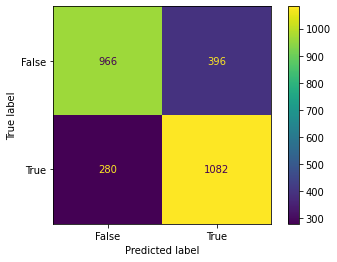

In [159]:
#False as positive label
plot_confusion_matrix(logistic,X=binary_test_df,y_true=binary_test_y)

In [161]:
logistic_binary_probs = [x[0] for x in logistic.predict_proba(binary_test_df)]

In [188]:
#average precision score of the logistic regression model
average_precision_score(binary_test_y,logistic_binary_probs,pos_label="False")

0.8726882821659991

In [168]:
#precision, recall and f1 score based on the model and default threshold
precision_recall_fscore_support(binary_test_y,binary_logistic_preds)

(array([0.7752809 , 0.73207037]),
 array([0.7092511 , 0.79441997]),
 array([0.74079755, 0.76197183]),
 array([1362, 1362]))

In [ ]:
data[data["binary"]=="True"]

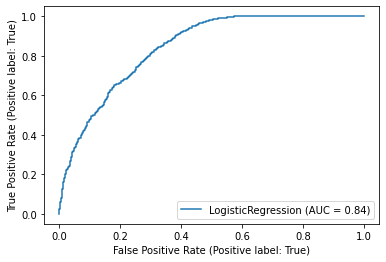

In [171]:
#AUC of the logistic regression model >0.8
plot_roc_curve(logistic,X=binary_test_df,y=binary_test_y)

### Decision Tree for Binary Classification

In [172]:
tree = DecisionTreeClassifier().fit(binary_train_df,binary_train_y)

In [174]:
tree_binary_probs = tree.predict_proba(binary_test_df)
tree_binary_preds = tree.predict(binary_test_df)

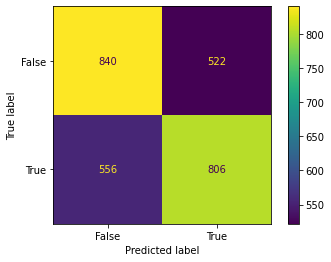

In [175]:
plot_confusion_matrix(tree,X=binary_test_df,y_true=binary_test_y)

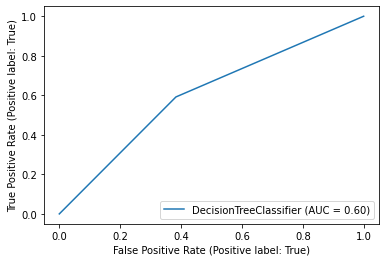

In [177]:
#AUC of the decision tree only 0.6
plot_roc_curve(tree,X=binary_test_df,y=binary_test_y)

<BarContainer object of 19 artists>

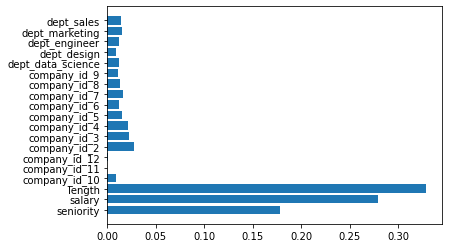

In [186]:
feat_imp = list(zip(binary_test_df.columns, tree.feature_importances_))
plt.barh([x[0] for x in feat_imp],[x[1] for x in feat_imp])

Logistic regression outperforms the decision tree, but we can use the tree to get some basic ideas of feature importance. For example, length of employment till prediction date seems to be the most important, which makes sense. Next two are salary and seniority, so these two factors are important to consider when thinking about potential churns

### 4. Further Research

We have identified a decent model in predicting future churns, however, because of inclusiong of a length feature, not all available data were eligible or used, and there might be implicit imbalance in some implicit features (for example in the testing set, all continuing employees join after 2014-07-01, so we might have left out some continuing employees joining before 2014-07-01, which were included in the training set)
- One further approach can be a simpler classification model without length of employment, so the test and train set can be made randomly. Also, importance of company, department, salary and seniority might be clearer without including length.
- Another approach can be looking closely at months and years where most employees churned, since that may indicate when company should focus more heavily on potential churns and prepare recruiting efforts.